In [1]:
# %%
import os
import numpy as np
import pandas as pd
from scipy.signal import stft, welch
from scipy.stats import kurtosis, skew
from scipy.fft import fft, fftfreq

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle, parallel_backend
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Set the renderer to browser
pio.renderers.default = 'browser'


In [10]:
# %%
# Function to compute time features
def compute_time_features(data, sample_rate):
    features = {}
    features['mean'] = np.mean(data)
    features['RMS'] = np.sqrt(np.mean(np.square(data)))
    features['StandardDeviation'] = np.std(data)
    features['ShapeFactor'] = np.sqrt(np.mean(np.square(data))) / np.mean(np.abs(data))
    features['SNR'] = np.mean(data) / np.std(data)
    features['THD'] = np.sqrt(np.sum(np.square(data[1:])) / np.square(data[0])) # Total Harmonic Distortion
    features['SINAD'] = np.mean(data) / np.sqrt(np.mean(np.square(data - np.mean(data))))
    features['PeakValure'] = np.max(np.abs(data))
    features['CrestFactor'] = np.max(np.abs(data)) / np.sqrt(np.mean(np.square(data)))
    features['ClearanceFactor'] = np.max(np.abs(data)) / np.mean(np.sqrt(np.abs(data)))
    features['ImpulseFactor'] = np.max(np.abs(data)) / np.mean(np.abs(data))
    return features

# Function to compute frequency features
def compute_frequency_features(data, sample_rate):
    freq_domain = np.abs(fft(data))
    freqs = fftfreq(len(data), 1 / sample_rate)
    features = {}
    features['MeanFrequency'] = np.mean(freq_domain)
    features['MedianFrequency'] = np.median(freq_domain)
    features['BandPower'] = np.sum(freq_domain ** 2)
    features['OccupiedBandwidth'] = np.sum(freq_domain > 0.05 * np.max(freq_domain))
    features['PowerBandwidth'] = np.sum(freq_domain > 0.5 * np.max(freq_domain))
    features['PeakAmplitude'] = np.max(freq_domain)
    features['PeakLocation'] = freqs[np.argmax(freq_domain)]
    return features

# Function to compute time-frequency features using STFT
def compute_time_freq_features(data, sample_rate):
    f, t, Zxx = stft( data, fs=sample_rate, nperseg=256)
    magnitude = np.abs(Zxx)

    features={}
    features['SpectralKurtosis'] = kurtosis(magnitude, axis=None)
    features['SpectralSkewness'] = skew(magnitude, axis=None)
    features['SpectralCrest'] = np.max(magnitude) / np.mean(magnitude)
    features['SpectralFlatness'] = np.exp(np.mean(np.log(magnitude))) / np.mean(magnitude)
    features['SpectralEntropy'] = -np.sum(magnitude * np.log2(magnitude), axis=None)
    features['SpectralCentroid'] = np.sum(f[:, np.newaxis] * magnitude, axis=0) / np.sum(magnitude, axis=0)
    features['SpectralSpread'] = np.sqrt(np.sum((f[:, np.newaxis] - features['SpectralCentroid'])**2 * magnitude, axis=0) / np.sum(magnitude, axis=0))
    features['SpectralRolloff'] = np.sum(magnitude, axis=0)[np.newaxis] * 0.85
    features['TFRidges'] = np.argmax(magnitude, axis=0)
    features['InstantaneousBandwidth'] = np.std(magnitude, axis=0)
    features['InstantaneousFrequency'] = np.mean(magnitude, axis=0)
    features['MeanEnvelopeEnergy'] = np.mean(np.abs(magnitude), axis=0)
    features['WaveletEntropy'] = -np.sum(np.square(magnitude) * np.log2(np.square(magnitude)), axis=None)
    return features

# Function to aggregate features
def aggregate_features(vector_data):
    aggregated_features = {}
    for key, vec in vector_data.items():
        aggregated_features[f'{key}_mean'] = np.mean(vec)
        aggregated_features[f'{key}_std'] = np.std(vec)
        aggregated_features[f'{key}_min'] = np.min(vec)
        aggregated_features[f'{key}_max'] = np.max(vec)
        aggregated_features[f'{key}_range'] = np.ptp(vec)
    return aggregated_features

# Function to normalize features
def normalize_features(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Main function to extract features from all CSV files in a folder
def extract_m_features(folder_path):
    feature_table = pd.DataFrame()
    sample_rate = 1428.57

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            data = np.loadtxt(file_path, delimiter=',')

            time_features = compute_time_features(data, sample_rate)
            frequency_features = compute_frequency_features(data, sample_rate)
            time_frequency_features = compute_time_freq_features(data, sample_rate)

            aggregated_time_frequency_features = aggregate_features(time_frequency_features)

            combined_features = {**time_features, **frequency_features, **aggregated_time_frequency_features}

            combined_feature_table = pd.DataFrame([combined_features])
            
            feature_table = pd.concat([feature_table, combined_feature_table], ignore_index=True)

    feature_table = feature_table.apply(normalize_features, axis=0)
    feature_table['HealthState'] = 0

    return feature_table


folder_path = "D:\MT dataset\mcsadc-IM motor-rotorbarfailure-2023\mcsadc-IM-motor-rotorbarfailure-OG\processed_CSV\SC_abc_healthy"
healthy_feature_table = extract_m_features(folder_path)


<>:96: SyntaxWarning:

invalid escape sequence '\M'

<>:96: SyntaxWarning:

invalid escape sequence '\M'

C:\Users\daryl\AppData\Local\Temp\ipykernel_29012\206737813.py:96: SyntaxWarning:

invalid escape sequence '\M'



In [11]:
# %%
combined_feature_table = pd.concat([healthy_feature_table, BB1_feature_table, BB2_feature_table], ignore_index=True)
X = combined_feature_table.drop(columns=['HealthState'])
y = combined_feature_table['HealthState']


In [12]:
# %%
# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Debug statement to print the normalized data
print('Normalized X data:')
print(X_normalized)

print('Y_numeric data:')
print(y)

# now 'X_normalized' contains the normalized features and 'y' contains the labels


Normalized X data:
[[ 1.24199002  1.40827779  1.40824697 ... -1.50097385 -1.50097385
          nan]
 [ 1.22559824  1.40935844  1.40933014 ... -1.50061066 -1.50061066
          nan]
 [ 1.19790983  1.49539046  1.49536673 ... -1.63901939 -1.63901939
          nan]
 ...
 [ 0.03519331 -1.00568613 -1.00555201 ...  0.82652624  0.82652624
          nan]
 [ 0.08539204 -1.00943859 -1.00930519 ...  0.82718438  0.82718438
          nan]
 [ 0.06860929 -1.01878551 -1.01865166 ...  0.831202    0.831202
          nan]]
Y_numeric data:
0      0
1      0
2      0
3      0
4      0
      ..
391    2
392    2
393    2
394    2
395    2
Name: HealthState, Length: 396, dtype: int64


c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\sklearn\utils\extmath.py:1140: RuntimeWarning:

invalid value encountered in divide

c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\sklearn\utils\extmath.py:1145: RuntimeWarning:

invalid value encountered in divide

c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\sklearn\utils\extmath.py:1165: RuntimeWarning:

invalid value encountered in divide



In [13]:
# %%
# Define data augmentation functions
def add_noise(data, noise_level=0.01):
    noise = noise_level * np.random.normal(size=data.shape)
    return data + noise

def scale(data, scaling_factor=1.1):
    return data * scaling_factor

def time_shift(data, shift_max=2):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift)

def augment_data(X, Y, augmentations=5):
    augmented_X, augmented_Y = [], []
    for _ in range(augmentations):
        for x, y in zip(X, Y):
            augmented_X.append(add_noise(x))
            augmented_X.append(scale(x))
            augmented_X.append(time_shift(x))
            augmented_Y.extend([y, y, y])
    return np.array(augmented_X), np.array(augmented_Y)

# Assuming X_normalized and y are already defined
# Augment the dataset
augmented_X, augmented_Y = augment_data(X_normalized, y)

# Combine original and augmented data
X_final = np.vstack((X_normalized, augmented_X))
y_final = np.hstack((y, augmented_Y))

# Shuffle the data
X_final, y_final = shuffle(X_final, y_final, random_state=42)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_final = imputer.fit_transform(X_final)

# Debug statement to print the normalized data
print('Final X data:')
print(X_final)

print('Final y:')
print(y_final)


Final X data:
[[ 1.27676040e+00 -7.95404143e-01 -7.95464947e-01 ...  7.75668140e-01
   7.75668140e-01 -1.68548756e-02]
 [ 1.05164546e+00 -8.21120626e-01 -8.21182346e-01 ...  7.26877354e-01
   7.26877354e-01 -1.68548756e-02]
 [ 8.73709063e-03 -9.95980004e-01 -9.98818300e-01 ...  8.24502663e-01
   8.20736309e-01 -1.68548756e-02]
 ...
 [ 1.20722296e+00 -1.34025997e-01 -1.35323546e-01 ...  3.38236048e-01
   3.35944560e-01 -1.68548756e-02]
 [-2.57883582e-01 -1.65267539e+00 -1.24746093e+00 ...  1.34729018e-04
  -1.23794979e+00 -2.57844772e-01]
 [-1.23698193e+00 -1.23689458e+00 -1.32816269e-01 ...  9.95604638e-01
  -2.49589093e-03 -8.58732563e-02]]
Final y:
[2 1 2 ... 0 0 0]


 ## Trainging Support Vector Machine model
 ### Using Recursive Feature Elimination with Grid Search Cross-Validation

c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning:

Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.



Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitt

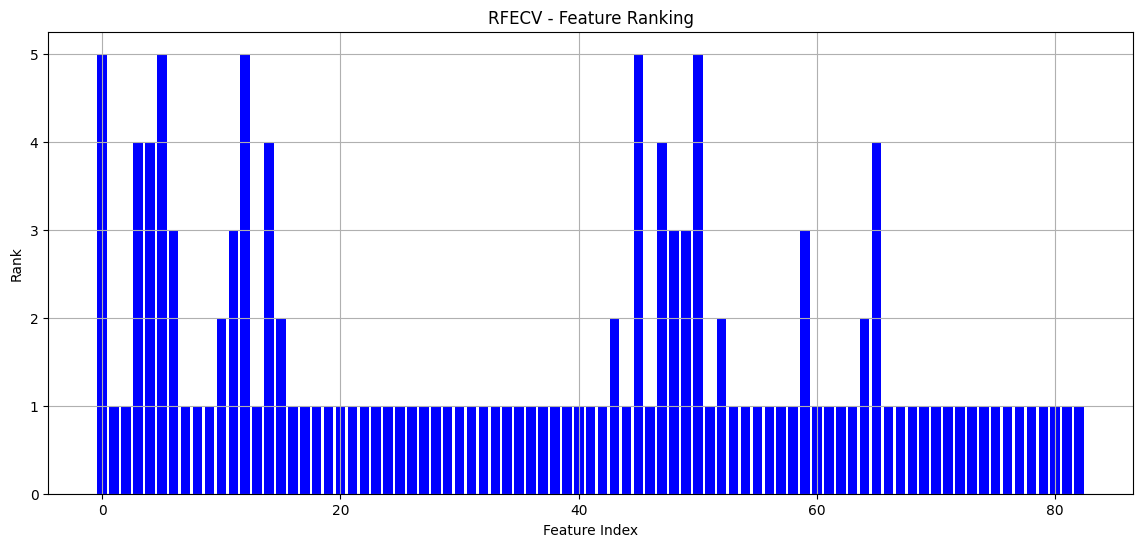

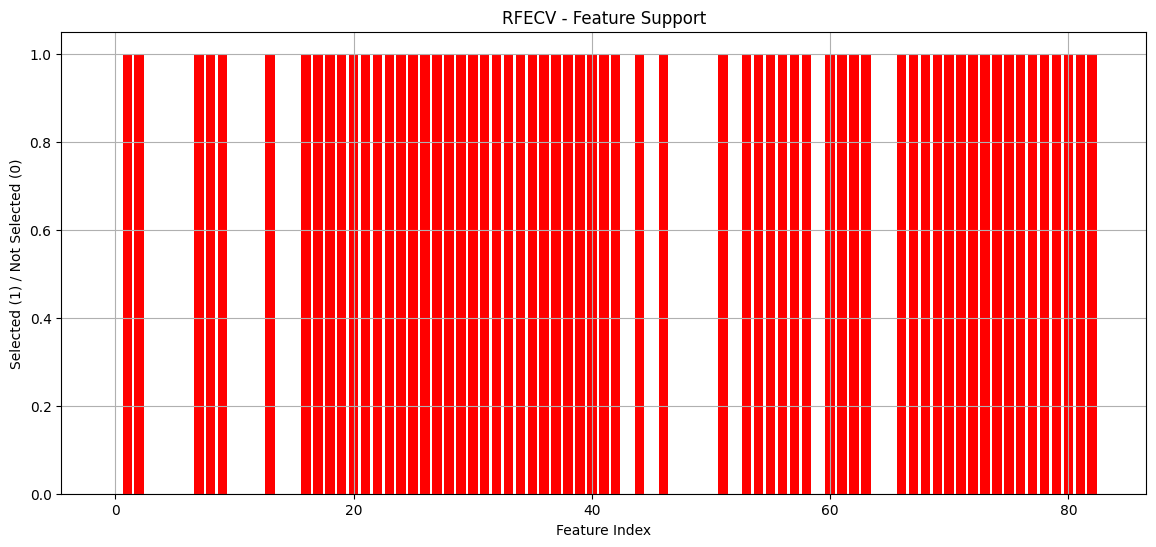

In [14]:
# %%
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Define the model and parameter grid for SVM
svm_model = SVC()
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Define the model and parameter grid for kNN
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Define the parameter grid for LinearSVC within RFECV
param_grid = {
    'estimator__C': [10, 20, 30, 40, 50, 100]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=RFECV(estimator=LinearSVC(max_iter=10000), step=5, cv=5, scoring='accuracy', n_jobs=-1, verbose=2),
                           param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

# Create the RFE (Recursive Feature Elimination) model with cross-validation for SVM with a linear kernel
# linear_svm = LinearSVC(max_iter=10000)
# Adjusting step parameter to reduce iterations
# rfecv = RFECV(estimator=linear_svm, step=2, cv=5, scoring='accuracy', min_features_to_select=15, n_jobs=-1, verbose=2)

# Fit the RFECV model
with parallel_backend('threading'):
    grid_search.fit(X_train, y_train)

# Get the best RFECV estimator
best_rfecv = grid_search.best_estimator_

# Get the selected features for SVM    
selected_features_svm = best_rfecv.support_

# Plot the number of features selected vs cross-validated score
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=list(range(1, len(best_rfecv.cv_results_["mean_test_score"]) + 1)),
    y=best_rfecv.cv_results_["mean_test_score"],
    mode='lines+markers',
    marker=dict(symbol='circle', size=8),
    line=dict(dash='dash')
))

fig1.update_layout(
    title='RFECV - No. of features selected vs Cross-Validated Score',
    xaxis_title='No. of features selected',
    yaxis_title='Cross-Validated Score (Accuracy)',
    template='plotly_white'
)

fig1.show()



# Plot the ranking of features
plt.figure(figsize=(14, 6))
plt.title('RFECV - Feature Ranking')
plt.xlabel('Feature Index')
plt.ylabel('Rank')
plt.bar(range(X_train.shape[1]), best_rfecv.ranking_, color='b', align='center')
plt.grid()
plt.show()

# Plot the support of features
plt.figure(figsize=(14, 6))
plt.title('RFECV - Feature Support')
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.bar(range(X_train.shape[1]), best_rfecv.support_, color='r', align='center')
plt.grid()
plt.show()


In [15]:
# %%

# Check the number of selected features
num_selected_features_svm = np.sum(selected_features_svm)
print(f"Number of selected features with optimized Linear SVC: {num_selected_features_svm}")

# Transform the training and test sets with the selected features
X_train_selected_svm = best_rfecv.transform(X_train)
X_test_selected_svm = best_rfecv.transform(X_test)



Number of selected features with optimized Linear SVC: 63


 ### Trying Principal Component Analysis for feature selection

In [ ]:
# %%
# Using PCA to reduce the number of features
n_components=20
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Print the number of features selected by PCA
print(f"Number of features after PCA: {n_components}")

# Plot the explained variance ratio to see the selection criteria
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by PCA components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()



 ### Coarse and detailed Grid Search SVM

In [16]:
# %%


# Create the pipeline with imputer and feature selection for SVM    # This is removed for now
# pipeline_svm = Pipeline([
    # ('imputer', SimpleImputer(strategy='mean')),
    # ('rfe', rfecv_svm),
# ])

# Coarse grid search to find the most promising hyperparameters
coarse_grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
coarse_grid_search_svm.fit(X_train_selected_svm, y_train)

# Narrow down the range for detailed search and USE THE BEST PARAMETERS from the coarse grid search for a more detailed search
best_params_svm = coarse_grid_search_svm.best_params_
detailed_param_grid_svm = {
    'kernel': [best_params_svm['kernel']],
    'C': [best_params_svm['C']/2, best_params_svm['C'], best_params_svm['C']*2],
    'gamma': [best_params_svm['gamma']]
}



Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [18]:
# %%

# Perform a detailed grid search
detailed_grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=detailed_param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
detailed_grid_search_svm.fit(X_train_selected_svm, y_train)

# Get the best SVM model
svm_best_estimator = detailed_grid_search_svm.best_estimator_



Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [19]:
# %%
# Evaluate SVM model on the test set
y_pred_svm = svm_best_estimator.predict(X_test_selected_svm)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

print("SVM selected features:", selected_features_svm)
print("SVM test accuracy:", svm_accuracy*100)


SVM selected features: [False  True  True False False False False  True  True  True False False
 False  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True False  True False
 False False False  True False  True  True  True  True  True  True False
  True  True  True  True False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
SVM test accuracy: 99.76340694006309


## Training k-Nearest Neighbour model
### Using SelectKBest feature selection along with Grid Search Cross Validation

In [ ]:
# Define the model and parameter grid for kNN
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create the SelectKBest feature selector
select_k_best = SelectKBest(score_func=f_classif, k=15)
select_k_best.fit(X_train, y_train)

# Define a pipeline
pipeline_knn = Pipeline([
    ('select_k_best', select_k_best),
    ('knn', knn_model)
])

# Perform grid search on the pipeline for kNN
grid_search_knn = GridSearchCV(estimator=pipeline_knn, param_grid=knn_param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit the kNN model
with parallel_backend('threading'):
    grid_search_knn.fit(X_train, y_train)

# Get the best kNN estimator
knn_best_pipeline = grid_search_knn.best_estimator_

# Plot the scores of the selected features
selected_features_indices = select_k_best.get_support(indices=True)
selected_scores = select_k_best.scores_[selected_features_indices]

plt.figure(figsize=(10, 6))
plt.title('SelectKBest - Feature Scores')
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.bar(selected_features_indices, selected_scores, color='b', align='center')
plt.grid()
plt.show()

In [24]:
# Predict the test set labels using the best pipeline
y_pred_knn = knn_best_pipeline.predict(X_test)

# Calculate the kNN accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn) * 100

print("kNN selected features:", selected_features_indices)
print("kNN test accuracy:, {:.2f}".format(knn_accuracy))

kNN selected features: [ 8 17 22 27 32 34 37 39 55 57 58 61 70 79 82]
kNN test accuracy:, 99.29
